# Model training
In this notebook a model is trained and evaluated on user drawings.

In [10]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import random
from torch.utils.data import DataLoader

from countryguess.data import Dataset, TestDataset, ValDataset, TripletDataset
from countryguess.utils import poly_to_img
from countryguess.model import Model
from countryguess.training import train, eval_fn

## Data

### Initialise datasets

In [2]:
ref_data = Dataset()
train_data = TripletDataset()
val_data = ValDataset()
test_data = TestDataset()

### Ploting the datasets

Training data

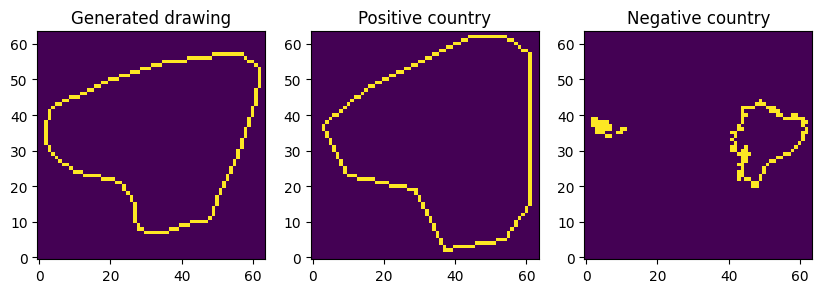

In [3]:
idx = random.randint(0, len(train_data) - 1)
sample = train_data[idx]

#Plotting
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
axs[0].imshow(np.swapaxes(sample["drawing"], 0, 1), interpolation='nearest', origin='lower')
axs[0].set_title("Generated drawing") 
axs[1].imshow(np.swapaxes(sample["pos_img"], 0, 1), interpolation='nearest', origin='lower')
axs[1].set_title("Positive country") 
axs[2].imshow(np.swapaxes(sample["neg_img"], 0, 1), interpolation='nearest', origin='lower')
axs[2].set_title("Negative country") 
plt.show()

Validation set

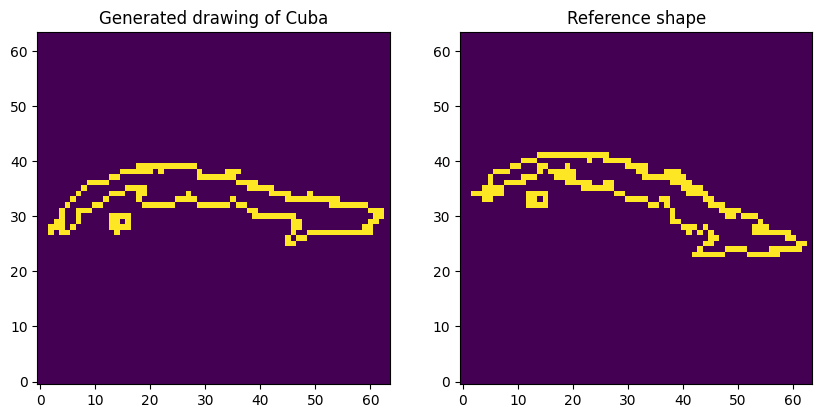

In [4]:
idx = random.randint(0, len(val_data) - 1)
sample = val_data[idx]

#Plotting
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.swapaxes(sample["drawing"], 0, 1), interpolation='nearest', origin='lower')
axs[0].set_title(f"Generated drawing of {sample['country_name']}") 

img = poly_to_img(ref_data.from_country_name(sample['country_name']), ref_data.shape)
axs[1].imshow(np.swapaxes(img, 0, 1), interpolation='nearest', origin='lower')
axs[1].set_title("Reference shape")
plt.show()

Test set (user drawings)

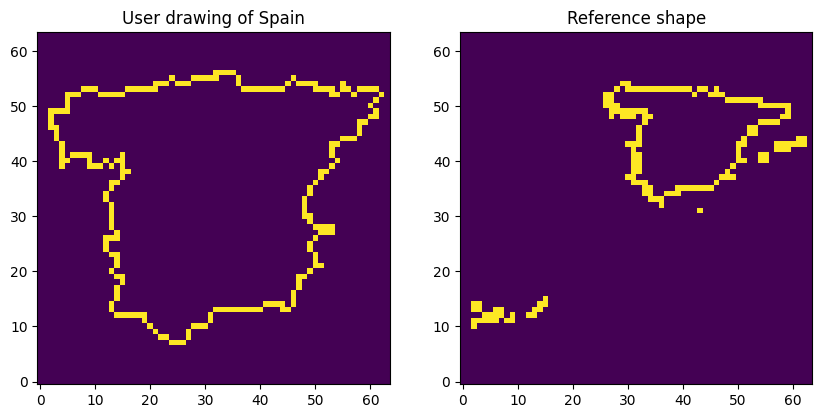

In [5]:
idx = random.randint(0, len(test_data) - 1)
sample = test_data[idx]

#Plotting
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.swapaxes(sample["drawing"], 0, 1), interpolation='nearest', origin='lower')
axs[0].set_title(f"User drawing of {sample['country_name']}") 

img = poly_to_img(ref_data.from_country_name(sample['country_name']), ref_data.shape)
axs[1].imshow(np.swapaxes(img, 0, 1), interpolation='nearest', origin='lower')
axs[1].set_title("Reference shape")
plt.show()

## Training model

In [6]:
train_dl = DataLoader(train_data, batch_size=32, shuffle=True)
val_dl = DataLoader(val_data, batch_size=32)

In [7]:
model = Model(dims=[1, 16, 32, 64, 80, 16*80, 96])
train(model, train_dl, val_dl, ref_data, epochs=30)

Epoch: 0	 loss: 0.379
Epoch: 0	 Average rank: 24.8	 top 10 acc: 69.2%	 top 1 acc: 38.5%	
Epoch: 1	 loss: 0.784
Epoch: 2	 loss: 0.398
Epoch: 3	 loss: 0.379
Epoch: 4	 loss: 0.296
Epoch: 5	 loss: 0.296
Epoch: 5	 Average rank: 6.0	 top 10 acc: 84.6%	 top 1 acc: 46.2%	
Epoch: 6	 loss: 0.172
Epoch: 7	 loss: 0.157
Epoch: 8	 loss: 0.123
Epoch: 9	 loss: 0.134
Epoch: 10	 loss: 0.087
Epoch: 10	 Average rank: 1.8	 top 10 acc: 100.0%	 top 1 acc: 61.5%	
Epoch: 11	 loss: 0.092
Epoch: 12	 loss: 0.088
Epoch: 13	 loss: 0.059
Epoch: 14	 loss: 0.067
Epoch: 15	 loss: 0.036
Epoch: 15	 Average rank: 3.8	 top 10 acc: 92.3%	 top 1 acc: 30.8%	
Epoch: 16	 loss: 0.059
Epoch: 17	 loss: 0.103
Epoch: 18	 loss: 0.036
Epoch: 19	 loss: 0.083
Epoch: 20	 loss: 0.060
Epoch: 20	 Average rank: 4.5	 top 10 acc: 92.3%	 top 1 acc: 61.5%	
Epoch: 21	 loss: 0.059
Epoch: 22	 loss: 0.047
Epoch: 23	 loss: 0.065
Epoch: 24	 loss: 0.031
Epoch: 25	 loss: 0.051
Epoch: 25	 Average rank: 2.6	 top 10 acc: 100.0%	 top 1 acc: 61.5%	
Epoch: 26

In [24]:
model.save_weights('./model_weights.npz')

## Evaluate model

In [17]:
test_dl = DataLoader(test_data, batch_size=16)

In [18]:
model.eval()
ranking = []
country_names = []
for batch in test_dl:
    rank = eval_fn(model, batch)
    ranking.extend(rank)
    country_names.extend(batch['country_name'])

In [19]:
print('Average rank: {:.1f}\t top 10 acc: {:.1f}%\t top 1 acc: {:.1f}%\t'
      .format(np.mean(rank)+1, 100*np.mean(rank < 10), 100*np.mean(rank < 1))) 

Average rank: 20.1	 top 10 acc: 71.4%	 top 1 acc: 57.1%	


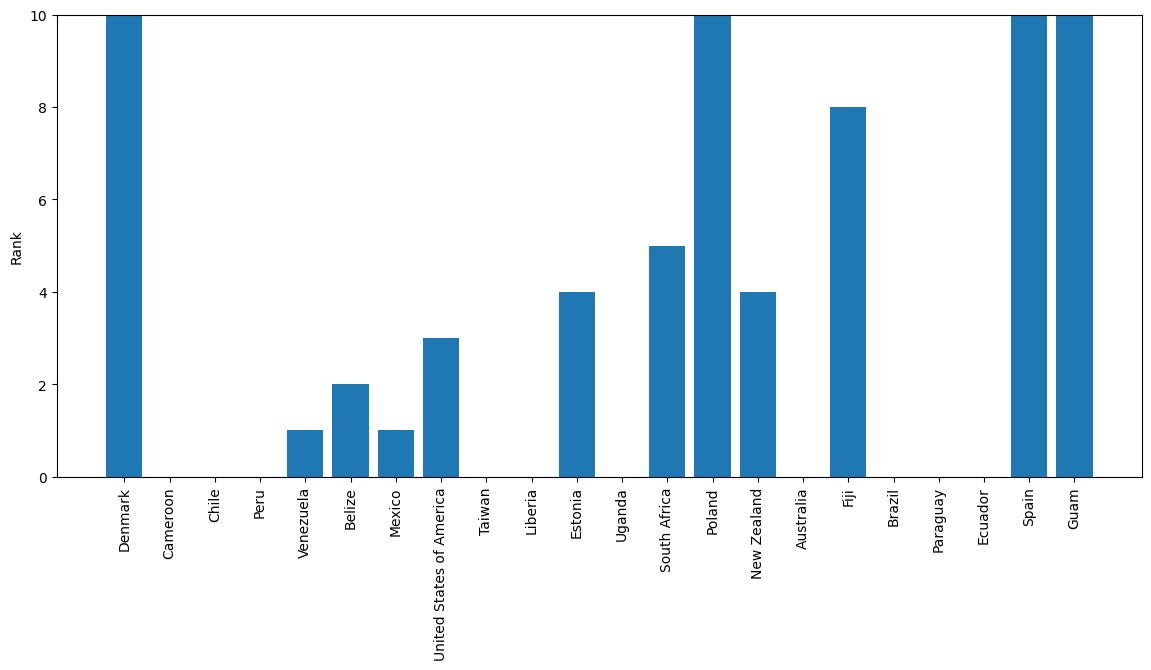

In [23]:
fig = plt.figure(figsize = (14, 6))
plt.bar(country_names, ranking)
plt.xticks(rotation=90)
plt.ylim((0, 10))
plt.ylabel("Rank")
plt.show()